In [ ]:
# default_exp primitives

# Primitives

> Implementations for vertex, edges, cell(s), and cell monolayer

In [ ]:
#hide
from nbdev.showdoc import *

- `Vertex`: stores 2D position of a given vertex 1x2 numpy array. Should implement a method for distance calculation.
- `Graph`: stores vertices and edges connecting the vertices
- `Monolayer`: Inherits graph object. Stores vertices, edges, boundary conditions, implements cells--a subset of vertices and edges that represents each cell (implements area, and perimeter calculations). Also should implement energy calculation together with its spatial gradient.

In [ ]:
#export
import torch
import numpy as np

In [ ]:
#export
class Vertex(object):
    '''Implements vertex and stores vertex position(s) as Nx2 (or any 2-D tensor) `torch.Tensor`:(x,y,...)'s.
    Rows represent points, columns the spatial dimensions, i.e. `[[x1,y1], [x2,y2], ...,[xN,yN]]`
    
    - Methods:
        - `dist(self,other)` : calculates Euclidean distance between two points (each row).
        - `zero_grad_(self)` : set all gradients to zero (used during gradient descent at each iter-n step).
        - `grad(self)` : get gradient w.r.t. each tensor in `self.x`
    - Properties :
        - `x` : use it to set/get location torch.tensor (returns or modifies self._x)
    '''
    def __init__(self,location=None,**kwargs):
        '''`location` must be (or convertible to)  2D `torch.tensor` w/ float dtype, set and get `location` with self.x
        
        Usage:
        `v = Vertex(torch.tensor([[3.,-1.]],requires_grad=True,dtype=torch.float64))`
        '''
        if location is not None:
            if type(location) is list:
                location = torch.tensor(location,**kwargs)
            elif type(location) is np.ndarray:
                location = torch.from_numpy(location)
            assert location.ndim==2, f"Input 'location' has wrong dimensions, location.ndim!=2 :'( "
        self._x=location
    
    def dist(self,other):
        ''' Calculate (Euclidean) distance to another vertex from self._x.'''
        return torch.norm(other.x - self._x,dim=1,p=2,keepdim=True)
    
    def zero_grad_(self):
        '''set gradients to zero if x.requires_grad==True'''
        if self._x.grad is not None:
            self._x.grad.data.zero_()
    
    def grad(self):
        '''Get accumulated gradients w.r.t. x (calculated with backprop; `torch.autograd`)'''
        return self._x.grad
    
    def requires_grad_(self,val):
        '''Access to `torch.tensor` method to change `requires_grad` status'''
        self._x.requires_grad_(val)
        
    def requires_grad(self):
        '''Access to `torch.tensor` method to view `requires_grad` status'''
        return self._x.requires_grad
    
    @property
    def x(self):
        return self._x
    @x.setter
    def x(self, val):
        self._x = val
    
    def __str__(self):
        return f"{self._x}"
    def __repr__(self):
        return f"Vertex {self._x}; dtype:{self._x.dtype}"
    

Initialization and calculating distances between vertices:
- When you initialize vertices with no input `v = Vertex()`, the location `v.x` is set to `None`.
- `Vertex(location)` accepts `torch.tensors`, list of lists that are convertible to tensors (with optional keyword arg-s for `torch.tensor()`), numpy.ndarrays (using `torch.from_numpy()`)
- `v.x` (i.e. location for `v=Vertex(location)`) is assumed to be Nx2 array (or any 2D array), and sizes are __not__ checked when set using `self.x`.

In [ ]:
# Define vertices with Nx2 torch tensors
o=Vertex()
o.x=torch.tensor([0.,0.]) # set to 0's (origin)
# or with location at init
v1=Vertex([[1.,1.]],dtype=torch.float32)
# calculate distance between vertices
r = o.dist(v1)
print(f"Distance between two vertices (o <--> v1) : {r.numpy().squeeze()}")

Distance between two vertices (o <--> v1) : 1.4142135381698608


Computing and resetting gradients:
- Example below demonstrates computing $\partial y/\partial v_{i,j}$ for $y = \sum_i\sum_j v_{i,j}^2$ using `torch.autograd`

In [ ]:
v = Vertex([[3.,-1.],[0.1,0.]],requires_grad=True,dtype=torch.float32)
# do some calculation with v.x
y = torch.sum(v.x**2)
# calculate grad-s
y.backward()
print('dy/dx_i after y.backward():\n',v.grad())
# set grad-s to zeros (useful when you don't want to accumulate grad-s)
v.zero_grad_()
print('dy/dx_i after zeroing grad-s:\n',v.grad())

dy/dx_i after y.backward():
 tensor([[ 6.0000, -2.0000],
        [ 0.2000,  0.0000]])
dy/dx_i after zeroing grad-s:
 tensor([[0., 0.],
        [0., 0.]])


### Example: A trapped particle in a 2D fluid
<a name="ex1"></a>
Let's assume linear drag, where force exerted by a spring is proportional to the velocity of the particle (drag force is $F_d=-b\frac{dx(t')}{dt'}$)
$$F_s(t') = -\nabla U = b\frac{dx(t')}{dt'}$$
where $U$ is the potential energy of the spring (e.g. optical trap) $U=k\cdot |r|^2$, where $r$ is the vector from equilibrium point, $o$, pointing to the current location of the particle, $x$. After re-defining time ($t'$) as a relative "scaled" time $t=\frac{t'}{b}$ and taking gradient of potential energy w.r.t. $x$, we can re-write the equation of motion (also let's set $o$ as origin $[0,0]$, then $r=x$)
$$\frac{dx(t)}{dt}=-2k(x-o)= -2kx$$
Let's numerically solve this equation ( _refer to the code cell below_ ). If the scale of the step size is chosen well (e.g. in the code below for large `k` use smaller `Dt`), solution $x(t)$ should converge to the equilibrium point $o$.

In [ ]:
#hide
import matplotlib.pylab as plt, numpy as np
from mpl_toolkits.mplot3d import axes3d

distance from origin (r):4.2426
Energy=kr^2 :18.0000
t=0: dE/dx=[[-6.0, 6.0]] --> dx/dt=-dE/dx=[[6.0, -6.0]]
Integration (Euler's method):
t=0.00:r=4.243; E=18; dx/dt=tensor([[ 6., -6.]], dtype=torch.float64)
t=0.80:r=0.617; E=0.38; dx/dt=tensor([[ 0.8724, -0.8724]], dtype=torch.float64)
t=1.60:r=0.090; E=0.008; dx/dt=tensor([[ 0.1268, -0.1268]], dtype=torch.float64)
t=2.40:r=0.013; E=0.00017; dx/dt=tensor([[ 0.0184, -0.0184]], dtype=torch.float64)
t=3.20:r=0.002; E=3.6e-06; dx/dt=tensor([[ 0.0027, -0.0027]], dtype=torch.float64)


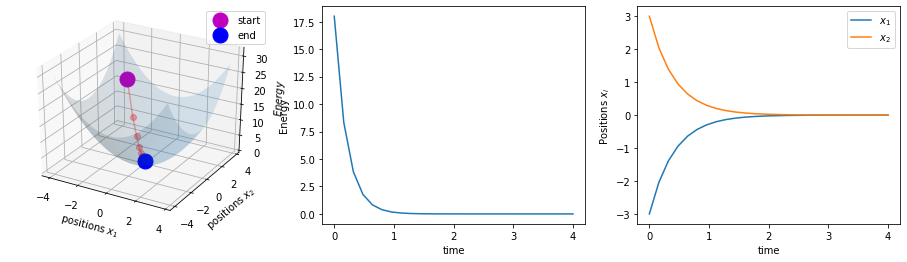

In [ ]:
o  = Vertex(torch.tensor([[0,0]],dtype=torch.float64)) # equilibrium point (where U(x) is minimum)
v1 = Vertex(torch.tensor([[-3,3]],requires_grad=True,dtype=torch.float64)) # particles location
r = o.dist(v1)
print(f'distance from origin (r):{r.item():.4f}')
# Define energy
k = 1.0
energy = lambda r: k*r**2
E = energy(r)
print(f'Energy=kr^2 :{E.item():.4f}')
# compute gradients
E.backward()
dEdx = v1.grad().data
dxdt = -dEdx
print(f't=0: dE/dx={dEdx.tolist()} --> dx/dt=-dE/dx={dxdt.tolist()}')
# Numerical integration
Dt = .16 # time step size
positions = [v1.x.tolist()]
t = [0]
Energies = []
print('Integration (Euler\'s method):')
for n in range(25):
    v1.zero_grad_()
    E = energy(o.dist(v1))  # elastic energy, o.dist(v1) is distance from vertex "o"
    Energies.append(E.item())
    E.backward()   # compute gradients
    dxdt = -v1.grad().data# dx/dt=-dE/dx
    if n%5==0:
        print(f't={Dt*n:.2f}:r={o.dist(v1).item():4.3f}; E={E.item():.2g}; dx/dt={dxdt}')
    # Update vertex position
    with torch.no_grad():
        v1.x += dxdt*Dt
    positions.append(v1.x.tolist()); t.append(t[-1]+Dt)
Energies.append( energy(o.dist(v1)).item() )

# Display the results
positions = np.array(positions).squeeze() # convert to a np array
fig = plt.figure(figsize=plt.figaspect(0.25))
# Energy as a function of position
ax = fig.add_subplot(1, 3, 1, projection='3d')
# Plot the Energy surface
Xmesh,Ymesh = np.meshgrid(np.arange(-4,4,.25),np.arange(-4,4,.25))
Zmesh = k*((Xmesh-o.x[0,0].numpy())**2+(Ymesh-o.x[0,1].numpy())**2) # potential energy surface
ax.plot_surface(Xmesh,Ymesh, Zmesh, alpha=0.15)
# Plot trajectory of the vertex E,x1,x2
ax.plot(positions[:,0],positions[:,1],Energies,'ro-',alpha=.3)
ax.plot(positions[:1,0],positions[:1,1],Energies[:1],'mo',ms=15,label='start')
ax.plot(positions[-1:,0],positions[-1:,1],Energies[-1:],'bo',ms=15,label='end')
ax.set_xlabel('positions $x_1$'); ax.set_ylabel('positions $x_2$'); ax.set_zlabel('$Energy$'); plt.legend();
# Energy as function of time
ax = fig.add_subplot(1, 3, 2); ax.plot(t,Energies); ax.set_xlabel('time'); ax.set_ylabel('Energy')
# 
ax = fig.add_subplot(1, 3, 3)
ax.plot(t,positions);plt.legend(['$x_1$','$x_2$']); ax.set_ylabel('Positions $x_i$'); ax.set_xlabel('time');
plt.show()

In [ ]:
#export
class Graph(object):
    '''Implements graph object. Stores vertices and edges.
    
    - Methods:
        - `length(self)` : calculates (Euclidean) edge lengths for each edge in the graph.
        - `direction(self)`: calculates edge vectors (`second_vertex - first_vertex` positions)
        - `get_vertex_grad(self)`: returns accumulated gradients w.r.t. to vertex positions.
        - `set_zero_grad_(self)`: sets gradients w.r.t. to vertex positions to zeros.
    - Properties :
        - `edges` : edges connecting vertices. Nx2 array of integers (vertex indices).
        - `vertices` : variable vertices represented by `Vertex` object.
        - `fixed`: constant (fixed boundary) vertices represented by `Vertex` object.
        Provided for convenience, turn off gradient calculation separately from "variable" vertices to keep them constant.
        '''
    def __init__(self,edges=None,vertices=None,fixed=None):
        '''Init-n function for `Graph` objects. Stores vertices and edges.
        
        Usage:
            `g = Graph(edges=torch.tensor([[0,1],[1,2],[2,0]]), vertices=Vertex(torch.tensor([[1,1],[0,-1],[-1,0]]))`
        ''' 
        self._edges = edges
        self._vertices = vertices
        self._fixed= fixed
    
    def length(self):
        ''' Calculates all edge lengths in the graph. Lengths--(Euclidean) distances between vertex pairs connected with edges.'''
        return torch.norm(self.vertices.x[self.edges[:,1],:] - self.vertices.x[self.edges[:,0],:],
                          dim=1,p=2,keepdim=True)
        
    def direction(self):
        '''Calculates edge vector (direction) from first vertex to its pair connected with an edge.'''
        return self.vertices.x[self.edges[:,1],:] - self.vertices.x[self.edges[:,0],:]
    
    def get_vertex_grad(self):
        '''Get accumulated gradients w.r.t. vertex positions (`self.vertices.x`) (calculated with backprop; `torch.autograd`)'''
        return self.vertices.grad()
    
    def set_zero_grad_(self):
        '''Set gradients to zero if `requires_grad` is set to `True` for variable vertices. Uses `vertices.zero_grad_()`'''
        self.vertices.zero_grad_()
        
    @property
    def edges(self):
        return self._edges
    @edges.setter
    def edges(self,val):
        self._edges = val
    
    @property
    def vertices(self):
        return self._vertices
    @vertices.setter
    def vertices(self, val):
        self._vertices = val
    
    def __str__(self):
        return f"{self._edges.tolist()}"
    def __repr__(self):
        return f"Graph\nedges {self.edges}...;dtype:{self.edges.dtype}\nvertices {self.vertices}"
    

Initilizing `Graph` objects
- Provide vertices (as `Vertex` object) and edges (connected vertex indices) at initialization, or set it later with `self.vertices` and `self.edges` property setters.

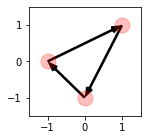

In [ ]:
g = Graph(edges=torch.tensor([[0,1],[1,2],[2,0]]),
          vertices=Vertex(torch.tensor([[1,1],[0,-1],[-1,0]],dtype=torch.float64,requires_grad=True)))
# Plot vertex positions
plt.figure(figsize=[2,2])
plt.plot(g.vertices.x.detach()[:,0], g.vertices.x.detach()[:,1],'ro',ms=15,alpha=.25);# this plots all vertices

# plot directed edges to check them, to calculate direction use `direction()` function in Graph object
quiver_kwargs = {'units':'xy','angles':'xy','scale_units':'xy','scale':1.0,'headwidth':3,'headlength':4,'width':.07}
# here I'm detaching edge_dirs vectors (if requires_grad==True) in order to use it later with plt.quiver:
edge_dirs = g.direction().detach()
# vertices with edges:
vertices = {'x': g.vertices.x.detach()[g.edges[:,0],0], 'y': g.vertices.x.detach()[g.edges[:,0],1] }
plt.quiver(vertices['x'], vertices['y'],edge_dirs[:,0],edge_dirs[:,1],**quiver_kwargs)
plt.axis([-1.5,1.5,-1.5,1.5]);plt.show()

Evaluating functions that depend on vertex positions (edge Euclidean length, and direction functions are already implemented in `Graph` class)
- Example below illustrates how to compute spatial gradient $\frac{\partial E}{\partial x_i}$ for $E(\{x_i\})=\sum_{edges}l_{ij}^2$ for vertices shown in the graph above

In [ ]:
# do something with vertex positions
l = g.length()
E = torch.sum(l**2)
# compute gradients w.r.t. variables of y() 
E.backward()
dEdx=g.get_vertex_grad().tolist() # here I'm copying grad-s into dydv list
# reset gradients to zeros (useful for iterative calculations s.a. gradient descent)
g.set_zero_grad_()
dEdx_2=g.get_vertex_grad().tolist()
print(f'dydv={dEdx}\n---\nafter zeroing gradients\ndydv={dEdx_2}')

dydv=[[6.0, 6.0], [0.0, -6.0], [-6.0, 0.0]]
---
after zeroing gradients
dydv=[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]


 ### Example: model of attracting particles in a fluid (2D model)

Now, let's evolve in time a system decribed by a potential $U=k\sum_{<i,j>}|x_i-x_j|^2=k\sum_{<i,j>}l^2_{ij}$, where every vertex $i$ is connected to all the other vertices $j$ with edges $<i,j>$, and $x_i$ is the position of vertex $i$ on a 2D plane (vector). Force balance equation, same as [Example 1](#ex1), for this system is $b\frac{dx(t')}{dt'}=-\nabla U$, but now $\nabla U$ is a function of distances (edge lengths $l_{ij}$, scalars) between all possible pairs of vertices. So the equation of motion for every vertex is (with $t=t'/b$)
$$\frac{dx_i}{dt}=-k\sum_{\forall ij|j\neq i}2(x_i-x_j)= 2k\sum_{\forall ij|j\neq i}(x_j-x_i)$$
This model system can be described by a complete graph ($G$). In order to demonstrate how to work with such systems, let's create a complete graph with $N_v$ vertices:

In [ ]:
#hide
def plot_example_graph(Xv,edges):
    for ij in edges:
        plt.plot([Xv[ij[0],0], Xv[ij[1],0]], [Xv[ij[0],1], Xv[ij[1],1]],'g-',lw=2,alpha=.2)
    plt.plot(Xv[:,0],Xv[:,1],'mo',ms=10,alpha=.5)
    plt.axis('equal')
    plt.axis(False);

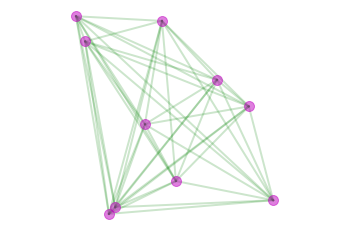

In [ ]:
np.random.seed(42) # let's seed RNG for sanity and reproducibility
Nv = 10 # number of vertices
Xv = np.random.uniform(0,1,(Nv,2)) # initial vertex potions sampled from uniform distribution [0,4)
edges = [[i,j] for i in range(Nv) for j in range(i+1,Nv) if i!=j] # list of edges for complete graph
plot_example_graph(Xv,edges)

- Note: in the code below, `Dt` must be smaller for large $Nv$ (e.g. $0.01$ for $Nv=10$, and about $0.001$ for $Nv=100$)

Number of vertices: 10 
Number of edges: 45 
Requires grad?: True
Integration (Euler's method):
t=0.001: E=   16; aver |dx/dt|= 2.563107211445399
t=0.032: E=  4.6; aver |dx/dt|= 1.3634743426148466
t=0.063: E=  1.3; aver |dx/dt|= 0.7253158489303371
t=0.095: E= 0.37; aver |dx/dt|= 0.3858401029392474


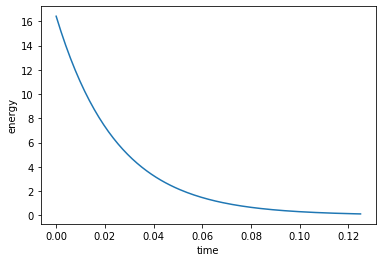

In [ ]:
# initialize a graph
G = Graph(edges=torch.tensor(edges), vertices=Vertex(torch.from_numpy(Xv).clone(),requires_grad=True, dtype=torch.float64) )
G.vertices.requires_grad_(True) # turn on `Vertex` gradients; check its status with G.vertices.requires_grad()
print('Number of vertices:',G.vertices.x.size(0),'\nNumber of edges:', G.edges.size(0),
      '\nRequires grad?:',G.vertices.requires_grad())

# Define energy function
k=1.0
energy = lambda l: k*torch.sum(l**2) # E = k sum(l_ij ^2)
# Numerical integration
Dt = 2**-10 # time step size
positions = [G.vertices.x.clone()]
t = [0]
Energies = []
print('Integration (Euler\'s method):')
for n in range(128):
    G.set_zero_grad_() # reset grad accumulator
    E = energy(G.length())  # total potential energy of the system
    Energies.append(E.item()) # E(t-1)
    E.backward() # compute gradients
    dxdt = -G.get_vertex_grad() # dx/dt=-dE/dx
    # Update vertex position
    with torch.no_grad():
        G.vertices.x += dxdt*Dt
    positions.append(G.vertices.x.clone())
    t.append(t[-1]+Dt)
    if n%32==0:
        print(f't={t[-1]:4.3f}: E={E.item():5.2g}; aver |dx/dt|= {torch.sum(dxdt**2)**.5/dxdt.size(0)}')
Energies.append( energy(G.length()).item() )
plt.plot(t,Energies);plt.xlabel('time');plt.ylabel('energy');

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots()
xy_min = min(0.0,positions[0].min().item())
xy_max = max(1.0,positions[0].max().item())
ax.axis('square')
ax.axis([xy_min,xy_max,xy_min,xy_max])
ax.axis(False)
edge_lines = []
for ij in G.edges:
    edge_line, = ax.plot([], [],'g-', lw=2,alpha=.2)
    edge_lines.append(edge_line)
node_dots, = ax.plot([], [], 'mo',ms=10,alpha=.5)
def init():
    ax.set_title(f"{t[0]:4.3f}")
    for edge_line in edge_lines:
        edge_line.set_data([], [])
    node_dots.set_data([], [])
    return (*edge_lines,node_dots)
def animate(i):
    ax.set_title(f"t={t[i]:4.3f}")
    xy = positions[i].detach().numpy()
    for k,edge_line in enumerate(edge_lines):
        ij = G.edges[k,:].numpy()
        edge_line.set_data([xy[ij[0],0],xy[ij[1],0]], [xy[ij[0],1],xy[ij[1],1]])
    node_dots.set_data(xy[:,0], xy[:,1])
    return (*edge_lines,node_dots)
f_anim = animation.FuncAnimation(fig, animate, init_func=init, frames=range(0,len(positions),max(1,round(len(positions)/64))), interval=500)
plt.close()
HTML(f_anim.to_jshtml()) # using HTML from IPython.display and matplotlib's animation module

- to-do:
    - plotting functions for vertices, graphs, cells and monolayers
    - add edge class to store vertex pairs, and edge ids; it should have method for length calculation.
    - add area using ["shoelace formula"](https://en.wikipedia.org/wiki/Shoelace_formula) another [link](https://www.mathopenref.com/coordpolygonarea.html) 

In [ ]:
#hide
# run this as a last cell in your notebook to export this module
from nbdev.export import *
notebook2script()

Converted 00_primitives.ipynb.
Converted index.ipynb.
